In [ ]:
# This will import the autoreload extension
%load_ext autoreload

# This will set autoreload to reload all modules (excluding those that can't be reloaded)
%autoreload 2

# Focusing:

### RDA:

In [2]:
from pathlib import Path
from SARLens.processor.focus import coarseRDA
from SARLens.utils.io import load, plot_with_cdf
import torch
from joblib import Parallel, delayed
import logging

import copy

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def find_decoded_pkts(pkt_n, folder):
    f = list(Path(folder).iterdir())
    # meta:
    m = [x for x in f if 'metadata' in x.name]
    m = [x for x in m if f'pkt_{pkt_n}' in x.name]
    # prod:
    p = [x for x in f if not 'metadata' in x.name]
    p = [x for x in p if f'pkt_{pkt_n}' in x.name]
    # eph:
    e = [x for x in f if 'ephemeris' in x.name]
    
    return load(p[0]), load(m[0]), load(e[0])

def get_RDA(radar_slice, ephemeris, metadata_slice):
    # Ensure that radar_processor is created fresh for each thread to avoid sharing issues
    radar_processor = coarseRDA(
        raw_data={'echo': radar_slice, 'ephemeris': ephemeris, 'metadata': metadata_slice},
        verbose=False,
        backend='torch'
    )
    
    return copy.deepcopy(radar_processor)

def process_radar_data(slice_start, slice_end, radar_data, ephemeris, metadata):
    logging.info(f'Processing slice from {slice_start} to {slice_end}')
    radar_slice = radar_data[slice_start:slice_end, :]
    metadata_slice = copy.deepcopy(metadata[slice_start:slice_end])
    ephemeris = copy.deepcopy(ephemeris)
    # Ensure that radar_processor is created fresh for each thread to avoid sharing issues
    radar_processor = get_RDA(radar_slice, ephemeris, metadata_slice)
    
    radar_processor.data_focus()
    d = radar_processor.radar_data
    del radar_processor
    return d

def parallel_process(radar_data, ephemeris, metadata, slice_size = 4096, n_jobs = 6):
    num_slices = radar_data.shape[0] // slice_size
    results = Parallel(n_jobs=n_jobs,prefer='threads' ,verbose=10)(delayed(process_radar_data)(i * slice_size, (i + 1) * slice_size, radar_data, ephemeris, metadata) for i in range(2))
    return results

In [3]:
pkt_n = 1
slice_size = 4096  # Adjust as needed
n_jobs = 4

output_folder = '/Data_large/marine/PythonProjects/AutoFocusNet/Data/CALIFORNIA/decoded/S1A_S1_RAW__0SDV_20180728T014205_20180728T014237_022988_027EB4_ACC6.SAFE'
radar_data, metadata, ephemeris = find_decoded_pkts(pkt_n, output_folder)

# Convert radar data to torch tensor
radar_data = torch.from_numpy(radar_data).to("cpu")
# Parallel processing
results = parallel_process(radar_data, ephemeris, metadata, slice_size, n_jobs)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
2024-07-11 08:19:12,573 - INFO - Processing slice from 0 to 4096
2024-07-11 08:19:12,575 - INFO - Processing slice from 4096 to 8192


Selected device: cpu
Selected device: cpu
Elapsed time for _prompt_tx_replica: 0.2392 seconds
Elapsed time for _prompt_tx_replica: 1.1865 seconds
Elapsed time for fft2D: 2.6576 secondsElapsed time for fft2D: 2.6364 seconds

Elapsed time for get_range_filter: 0.1093 seconds
Elapsed time for get_range_filter: 0.1101 seconds
Elapsed time for _compute_effective_velocities: 2.3203 seconds
Elapsed time for _compute_effective_velocities: 2.6506 seconds
Elapsed time for get_RCMC: 10.0242 seconds
Elapsed time for get_RCMC: 10.6012 seconds
Elapsed time for ifft_rg: 0.8447 seconds
Elapsed time for ifft_rg: 0.9244 seconds
Elapsed time for get_azimuth_filter: 10.8084 seconds
Elapsed time for get_azimuth_filter: 11.0416 seconds
Elapsed time for ifft_az: 0.2995 seconds
RAM memory usage: 22.1%
Elapsed time for data_focus: 49.5488 seconds
Elapsed time for ifft_az: 0.2716 seconds
RAM memory usage: 18.9%
Elapsed time for data_focus: 60.5012 seconds


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.0min finished


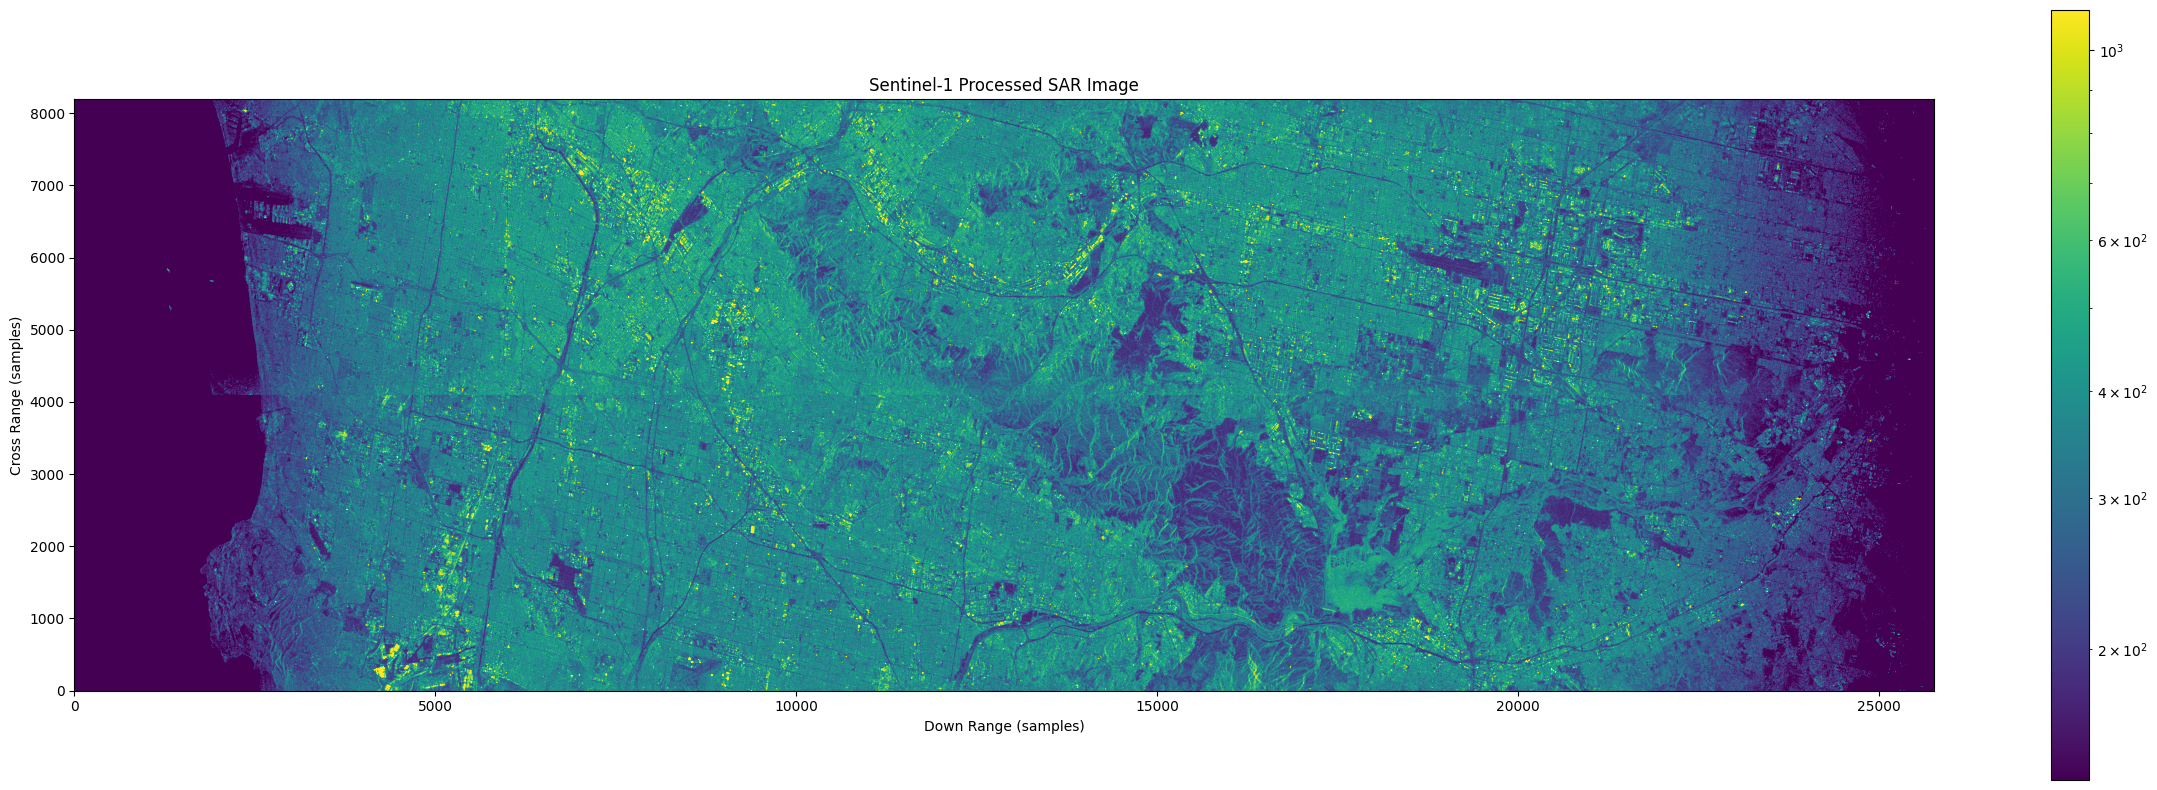

In [4]:
import numpy as np 

plot_with_cdf(np.vstack(list(results[k] for k in range(2))), (30,10))